# GroupfMRI17a - Control analyses - run same analysis with 5, 15, and 20 hidden regions, but ROIs with the LEAST SIMILARITY TO ANN'S RDM
## Task context regions are a single set; including regions that decode 12 task rules
#### Analysis 1 - Full model, SRActFlow decoding
#### Control 1 - Remove nonlinearities
#### Run a standard permutation test, shuffling labels on predicted activation patterns to decode held-out activations


Takuya Ito

10/24/2019

In [401]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
import scipy.stats as stats
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
import h5py
import tools_group_rsa_python3 as tools_group
import nibabel as nib
import EmpiricalSRActFlow_ANN_RSA_v3 as esr
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "FreeSans"
import pandas as pd
import time
from importlib import reload


In [402]:
cabn_l = np.squeeze(nib.load('/projects3/AnalysisTools/ColeAnticevicNetPartition/SeparateHemispheres/Q1-Q6_RelatedParcellation210.L.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii').get_data())
cabn_r = np.squeeze(nib.load('/projects3/AnalysisTools/ColeAnticevicNetPartition/SeparateHemispheres/Q1-Q6_RelatedParcellation210.R.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii').get_data())+180
cabn = np.hstack((cabn_l,cabn_r))

In [4]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']



basedir = '/projects3/SRActFlow/'

# Using final partition
# networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
# Swap so that it's R->L
networkdef = np.loadtxt('/projects3/AnalysisTools/ColeAnticevicNetPartition/cortex_parcel_network_assignments.txt')
networkdef = np.hstack((networkdef[180:],networkdef[:180]))
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects3/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

# Load real motor response data

In [5]:
tools_group = reload(tools_group)
nResponses = 2
data_task_rh = np.zeros((len(glasser2),nResponses,len(subjNums)))
data_task_lh = np.zeros((len(glasser2),nResponses,len(subjNums)))

scount = 0
for subj in subjNums:
    data_task_rh[:,:,scount] = np.real(tools_group.loadMotorResponses(subj,hand='Right'))
    data_task_lh[:,:,scount] = np.real(tools_group.loadMotorResponses(subj,hand='Left'))
    scount += 1

#### Identify target vertices

In [792]:
# Set indices for layer-by-layer vertices
targetdir = '/projects3/SRActFlow/data/results/GroupfMRI/MotorResponseDecoding/'
motor_resp_regions_LH = np.loadtxt(targetdir + 'MotorResponseRegions_LH.csv',delimiter=',')
motor_resp_regions_RH = np.loadtxt(targetdir + 'MotorResponseRegions_RH.csv',delimiter=',')
targetROIs = np.hstack((motor_resp_regions_LH,motor_resp_regions_RH))

target_ind = []
for roi in targetROIs:
    roi_ind = np.where(glasser2==roi+1)[0]
    target_ind.extend(roi_ind)
target_ind = np.asarray(target_ind)

# 5 Hidden layers (least similar)

#### Load in FC mappings

In [793]:
tools_group = reload(tools_group)
n_hiddenregions = -5
inputtypes = ['color','ori','pitch','constant']
inputkeys = ['RED','VERTICAL','HIGH','CONSTANT']
fc_input2hidden = {}
eig_input2hidden = {}
i = 0
for inputtype in inputtypes:
    fc_input2hidden[inputkeys[i]], eig_input2hidden[inputkeys[i]] = tools_group.loadGroupActFlowFC(inputtype, n_hiddenregions=n_hiddenregions, pc_space=True)
    i += 1

fc_12rule2hidden, eig_12rule2hidden = tools_group.loadGroupActFlowFC('12', n_hiddenregions=n_hiddenregions, pc_space=True)
# Load hidden to motor resp mappings
fc_hidden2motorresp, eig_hidden2motorresp = tools_group.loadGroupActFlowFC('hidden2out', n_hiddenregions=n_hiddenregions, pc_space=True)

#### Generate trials to simulate empirical brain computational models

In [794]:
esr = reload(esr)
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_15stims_v2.csv' # Good
filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_15stims_v3.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_6stims_v1.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_50stims_v1.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/tmp.csv'
# esr.constructTasks(n_stims=6,filename=filename)

trial_metadata = pd.read_csv(filename)

#### Define wrapper function for SRActFlow

In [795]:
esr = reload(esr)
def subjSRActFlow_12Rule_PCFC(subj,trial_metadata,n_hiddenregions):
    print('Subject ' + subj + '... Simulating ' + str(len(trial_metadata)) + ' Trials')
    obj = esr.EmpiricalActFlow(subj)
    # Input
    obj.fc_input2hidden = fc_input2hidden
    obj.eig_input2hidden = eig_input2hidden
    # Rules
    obj.fc_12rule2hidden = fc_12rule2hidden
    obj.eig_12rule2hidden = eig_12rule2hidden
    # hidden 2 motor
    obj.fc_hidden2motorresp = fc_hidden2motorresp
    obj.eig_hidden2motorresp = eig_hidden2motorresp
    
    obj.extractAllActivations(trial_metadata)

    actflow = obj.generateActFlowPredictions_12Rule_PCFC(thresh=0,n_hiddenregions=n_hiddenregions,verbose=False)
    actflow_control = obj.generateActFlowPredictions_12Rule_PCFC(thresh=None,n_hiddenregions=n_hiddenregions,verbose=False)
    del obj
    return actflow, actflow_control

global fc_input2hidden
global fc_12rule2hidden

inputs = []
for i in range(len(subjNums)):
    inputs.append((subjNums[i],trial_metadata,n_hiddenregions))

timestart = time.time()
pool = mp.Pool(processes=8)
results = pool.starmap_async(subjSRActFlow_12Rule_PCFC,inputs).get()
pool.close()
pool.join()
timeend = time.time()
print("time elapsed:", timeend-timestart)

actflow_predictions = np.zeros((len(subjNums),len(target_ind),4))
actflow_predictions_control = np.zeros((len(subjNums),len(target_ind),4))
scount = 0
for result in results:
    actflow_predictions[scount,:,:] = result[0]
    actflow_predictions_control[scount,:,:] = result[1]
    scount += 1



Subject 023... Simulating 960 Trials
Subject 034... Simulating 960 Trials
Subject 027... Simulating 960 Trials
Subject 017... Simulating 960 Trials
Subject 013... Simulating 960 Trials
Subject 031... Simulating 960 Trials
Subject 041... Simulating 960 Trials
Subject 038... Simulating 960 Trials
Subject 039... Simulating 960 Trials
Subject 035... Simulating 960 Trials
Subject 014... Simulating 960 Trials
Subject 032... Simulating 960 Trials
Subject 024... Simulating 960 Trials
Subject 018... Simulating 960 Trials
Subject 028... Simulating 960 Trials
Subject 042... Simulating 960 Trials
Subject 033... Simulating 960 Trials
Subject 030... Simulating 960 Trials
Subject 026... Simulating 960 Trials
Subject 021... Simulating 960 Trials
Subject 040... Simulating 960 Trials
Subject 037... Simulating 960 Trials
Subject 043... Simulating 960 Trials
Subject 016... Simulating 960 Trials
Subject 045... Simulating 960 Trials
Subject 048... Simulating 960 Trials
Subject 053... Simulating 960 Trials
S

#### Compute average activity for each response, for each subject

In [796]:
## Threshold
# scount = 0
# actflow_rh = np.zeros(data_task_rh.shape)
# actflow_lh = np.zeros(data_task_lh.shape)
# for scount in range(len(subjNums)):
#     # RMID
#     actflow_rh[target_ind,0,scount] = np.multiply(actflow_predictions[scount,:,2],actflow_predictions[scount,:,2]>0)
#     # RIND
#     actflow_rh[target_ind,1,scount] = np.multiply(actflow_predictions[scount,:,3],actflow_predictions[scount,:,3]>0)
#     # LMID
#     actflow_lh[target_ind,0,scount] = np.multiply(actflow_predictions[scount,:,0],actflow_predictions[scount,:,0]>0)
#     # LIND
#     actflow_lh[target_ind,1,scount] = np.multiply(actflow_predictions[scount,:,1],actflow_predictions[scount,:,1]>0)

    
## No threshold
scount = 0
actflow_rh = np.zeros(data_task_rh.shape)
actflow_lh = np.zeros(data_task_lh.shape)
for scount in range(len(subjNums)):
    # RMID
    actflow_rh[target_ind,0,scount] = actflow_predictions[scount,:,2]
    # RIND
    actflow_rh[target_ind,1,scount] = actflow_predictions[scount,:,3]
    # LMID
    actflow_lh[target_ind,0,scount] = actflow_predictions[scount,:,0]
    # LIND
    actflow_lh[target_ind,1,scount] = actflow_predictions[scount,:,1]


## 5 HIDDEN - Run across subject decoding on right-hand motor responses

#### Run decoding

In [797]:
tools_group = reload(tools_group)
nproc = 20
nResponses = 2
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

# rois = np.asarray([7,8,52])
rois = np.asarray([8])
# rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])

# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind
#
## realdata = stats.zscore(data_task_rh[target_ind,:,:],axis=0).copy()
## flowdata = stats.zscore(actflow_rh[target_ind,:,:],axis=0).copy()
realdata = data_task_rh[roi_ind,:,:].copy()
flowdata = actflow_rh[roi_ind,:,:].copy()


distances_baseline_rh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_rh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True, featsel=False,confusion=True,
                                                          ncvs=ncvs, nproc=nproc)

#### Compute statistics

Activity flow accuracy = 0.34375
p = 0.9999910964822115
Permutation test p-value (permute all): 1.86


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Permutation test p-value (permute stim): 0.999
Permutation test p-value (permute context): 0.98


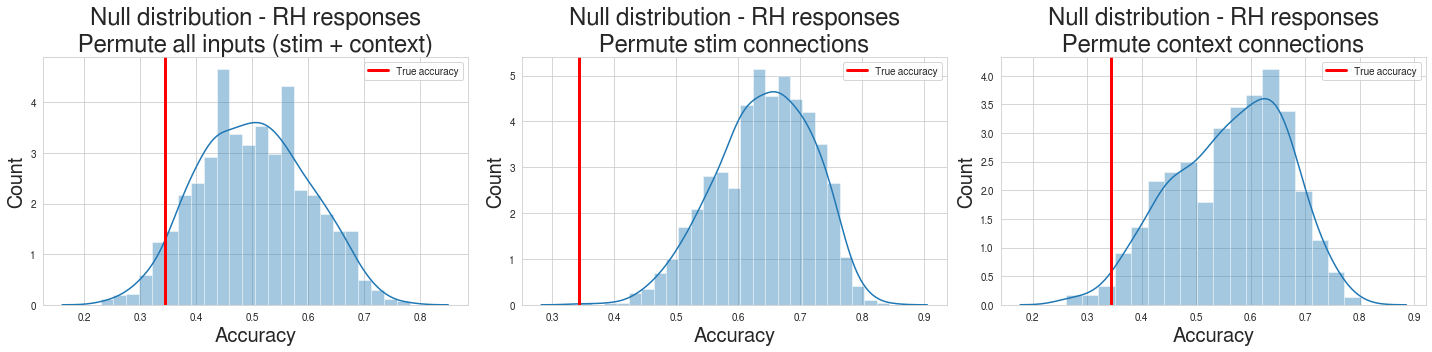

In [798]:
statistics_rh = np.zeros((distances_baseline_rh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_rh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_rh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_rh[0,0] = np.mean(distances_baseline_rh[0,:])
statistics_rh[0,1] = p

print('Activity flow accuracy =', statistics_rh[0,0])
print('p =', statistics_rh[0,1])
# print('Matched spatial correlation:', np.mean(rmatch))
# print('Mismatched spatial correlation:', np.mean(rmismatch))

plt.figure(figsize=(20,5))
plt.subplot(131)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_all.txt')
plt.title('Null distribution - RH responses\nPermute all inputs (stim + context)', fontsize=24)
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute all):', null_p)

plt.subplot(132)
plt.title('Null distribution - RH responses\nPermute stim connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_stim.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute stim):', null_p)

plt.subplot(133)
plt.title('Null distribution - RH responses\nPermute context connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_context.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute context):', null_p)


## Last 5 HIDDEN - Run across subject decoding on left-hand motor responses

#### Run decoding

In [799]:
tools_group = reload(tools_group)
nproc = 20
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputLH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

rois = np.asarray([187, 188, 231])
rois = np.asarray([188])
# rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])
    
# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_lh[roi_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_lh[roi_ind,:,:],axis=0).copy()
realdata = data_task_lh[roi_ind,:,:].copy()
flowdata = actflow_lh[roi_ind,:,:].copy()


distances_baseline_lh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_lh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,featsel=False,confusion=True,
                                                          ncvs=ncvs, nproc=nproc)
    

Activity flow accuracy = 0.6875
p = 1.0909303308852291e-07
Permutation test p-value (permute all): 0.036


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Permutation test p-value (permute stim): 0.043
Permutation test p-value (permute context): 0.0


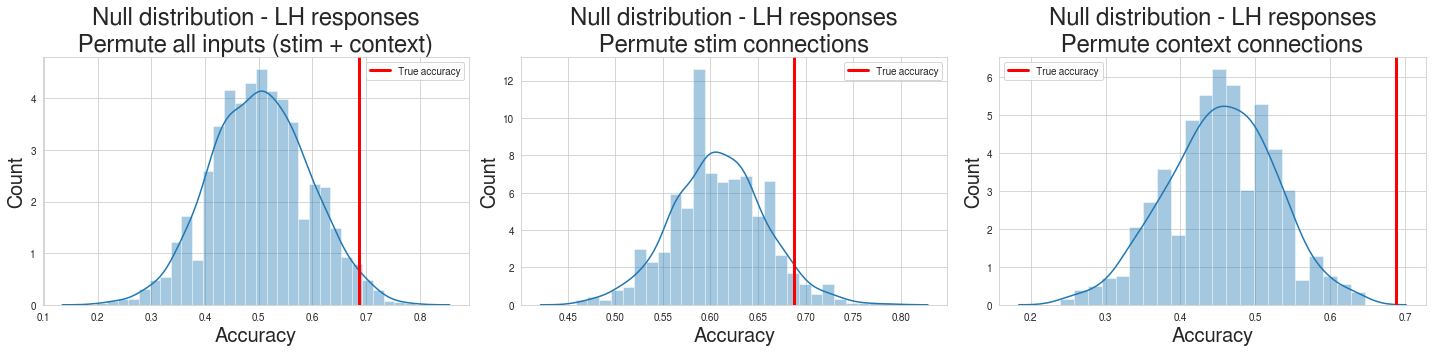

In [800]:
statistics_lh = np.zeros((distances_baseline_lh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_lh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_lh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_lh[0,0] = np.mean(distances_baseline_lh[0,:])
statistics_lh[0,1] = p

print('Activity flow accuracy =', statistics_lh[0,0])
print('p =', statistics_lh[0,1])
# print('Matched spatial correlation:', np.mean(rmatch))
# print('Mismatched spatial correlation:', np.mean(rmismatch))


plt.figure(figsize=(20,5))
plt.subplot(131)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_all.txt')
plt.title('Null distribution - LH responses\nPermute all inputs (stim + context)', fontsize=24)
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute all):', null_p)

plt.subplot(132)
plt.title('Null distribution - LH responses\nPermute stim connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_stim.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute stim):', null_p)

plt.subplot(133)
plt.title('Null distribution - LH responses\nPermute context connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_context.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute context):', null_p)


___

## Run analysis for Control (No threshold) variant

#### Compute average activity for each response, for each subject

In [801]:
scount = 0
actflow_rh_ctrl = np.zeros(data_task_rh.shape)
actflow_lh_ctrl = np.zeros(data_task_lh.shape)
for scount in range(len(subjNums)):
    # RMID
    actflow_rh_ctrl[target_ind,0,scount] = actflow_predictions_control[scount,:,2]
    # RIND
    actflow_rh_ctrl[target_ind,1,scount] = actflow_predictions_control[scount,:,3]
    # LMID
    actflow_lh_ctrl[target_ind,0,scount] = actflow_predictions_control[scount,:,0]
    # LIND
    actflow_lh_ctrl[target_ind,1,scount] = actflow_predictions_control[scount,:,1]


## 5 HIDDEN - (NO THRESHOLD CONTROL): Run across subject decoding on right-hand motor responses

#### Run decoding

In [802]:
tools_group = reload(tools_group)
nproc = 20
nResponses = 2
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]


# rois = np.asarray([8,52,9])-1
# rois = np.asarray([8,52])-1
# rois = np.where(networkdef==networkmappings['smn'])[0]
# rois = np.asarray([7,8,52])
rois = np.asarray([8])
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])

# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_rh[target_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_rh[target_ind,:,:],axis=0).copy()
realdata = data_task_rh[roi_ind,:,:].copy()
flowdata = actflow_rh_ctrl[roi_ind,:,:].copy()


distances_baseline_rh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_rh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,confusion=True,featsel=False,
                                                          ncvs=ncvs, nproc=nproc)

#### Compute statistics

In [803]:
statistics_rh = np.zeros((distances_baseline_rh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_rh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_rh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_rh[0,0] = np.mean(distances_baseline_rh[0,:])
statistics_rh[0,1] = p

print('Activity flow accuracy =', statistics_rh[0,0])
print('p =', statistics_rh[0,1])
print('Matched spatial correlation:', np.mean(rmatch))
print('Mismatched spatial correlation:', np.mean(rmismatch))



Activity flow accuracy = 0.4375
p = 0.9516582343118908
Matched spatial correlation: 0.0029174628553166166
Mismatched spatial correlation: 0.0062676763442360865


## 5 HIDDEN - (NO THRESHOLD CONTROL): Run across subject decoding on left-hand motor responses

#### Run decoding

In [804]:
tools_group = reload(tools_group)
nproc = 20
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputLH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]
# rois = np.asarray([188,189,232]) - 1
# rois = np.asarray([188,232]) - 1
# rois = np.asarray([189]) - 1
# rois = np.where(networkdef==networkmappings['smn'])[0]
# rois = np.asarray([187,188,231])
rois = np.asarray([188])
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])
    
# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_lh[roi_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_lh[roi_ind,:,:],axis=0).copy()
realdata = data_task_lh[roi_ind,:,:].copy()
flowdata = actflow_lh_ctrl[roi_ind,:,:].copy()


distances_baseline_lh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_lh[0,:],rmatch,rmismatch,confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,confusion=True,featsel=False,
                                                          ncvs=ncvs, nproc=nproc)
    

#### Compute statistics

In [805]:
statistics_lh = np.zeros((distances_baseline_lh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_lh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_lh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_lh[0,0] = np.mean(distances_baseline_lh[0,:])
statistics_lh[0,1] = p

print('Activity flow accuracy =', statistics_lh[0,0])
print('p =', statistics_lh[0,1])
print('Matched spatial correlation:', np.mean(rmatch))
print('Mismatched spatial correlation:', np.mean(rmismatch))



Activity flow accuracy = 0.4583333333333333
p = 0.8605091154818014
Matched spatial correlation: -0.00359286372011839
Mismatched spatial correlation: -0.00272014767366682


___

# 10 Hidden layers

#### Load in FC mappings

In [806]:
tools_group = reload(tools_group)
n_hiddenregions = -10
inputtypes = ['color','ori','pitch','constant']
inputkeys = ['RED','VERTICAL','HIGH','CONSTANT']
fc_input2hidden = {}
eig_input2hidden = {}
i = 0
for inputtype in inputtypes:
    fc_input2hidden[inputkeys[i]], eig_input2hidden[inputkeys[i]] = tools_group.loadGroupActFlowFC(inputtype, n_hiddenregions=n_hiddenregions, pc_space=True)
    i += 1

fc_12rule2hidden, eig_12rule2hidden = tools_group.loadGroupActFlowFC('12', n_hiddenregions=n_hiddenregions, pc_space=True)
# Load hidden to motor resp mappings
fc_hidden2motorresp, eig_hidden2motorresp = tools_group.loadGroupActFlowFC('hidden2out', n_hiddenregions=n_hiddenregions, pc_space=True)

#### Generate trials to simulate empirical brain computational models

In [807]:
esr = reload(esr)
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_15stims_v2.csv' # Good
filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_15stims_v3.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_6stims_v1.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_50stims_v1.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/tmp.csv'
# esr.constructTasks(n_stims=6,filename=filename)

trial_metadata = pd.read_csv(filename)

#### Define wrapper function for SRActFlow

In [808]:
esr = reload(esr)
def subjSRActFlow_12Rule_PCFC(subj,trial_metadata,n_hiddenregions):
    print('Subject ' + subj + '... Simulating ' + str(len(trial_metadata)) + ' Trials')
    obj = esr.EmpiricalActFlow(subj)
    # Input
    obj.fc_input2hidden = fc_input2hidden
    obj.eig_input2hidden = eig_input2hidden
    # Rules
    obj.fc_12rule2hidden = fc_12rule2hidden
    obj.eig_12rule2hidden = eig_12rule2hidden
    # hidden 2 motor
    obj.fc_hidden2motorresp = fc_hidden2motorresp
    obj.eig_hidden2motorresp = eig_hidden2motorresp
    
    obj.extractAllActivations(trial_metadata)

    actflow = obj.generateActFlowPredictions_12Rule_PCFC(thresh=0,n_hiddenregions=n_hiddenregions,verbose=False)
    actflow_control = obj.generateActFlowPredictions_12Rule_PCFC(thresh=None,n_hiddenregions=n_hiddenregions,verbose=False)
    del obj
    return actflow, actflow_control

global fc_input2hidden
global fc_12rule2hidden

inputs = []
for i in range(len(subjNums)):
    inputs.append((subjNums[i],trial_metadata,n_hiddenregions))

timestart = time.time()
pool = mp.Pool(processes=8)
results = pool.starmap_async(subjSRActFlow_12Rule_PCFC,inputs).get()
pool.close()
pool.join()
timeend = time.time()
print("time elapsed:", timeend-timestart)

actflow_predictions = np.zeros((len(subjNums),len(target_ind),4))
actflow_predictions_control = np.zeros((len(subjNums),len(target_ind),4))
scount = 0
for result in results:
    actflow_predictions[scount,:,:] = result[0]
    actflow_predictions_control[scount,:,:] = result[1]
    scount += 1



Subject 017... Simulating 960 Trials
Subject 013... Simulating 960 Trials
Subject 027... Simulating 960 Trials
Subject 034... Simulating 960 Trials
Subject 031... Simulating 960 Trials
Subject 041... Simulating 960 Trials
Subject 023... Simulating 960 Trials
Subject 038... Simulating 960 Trials
Subject 018... Simulating 960 Trials
Subject 028... Simulating 960 Trials
Subject 035... Simulating 960 Trials
Subject 039... Simulating 960 Trials
Subject 014... Simulating 960 Trials
Subject 024... Simulating 960 Trials
Subject 042... Simulating 960 Trials
Subject 032... Simulating 960 Trials
Subject 021... Simulating 960 Trials
Subject 030... Simulating 960 Trials
Subject 037... Simulating 960 Trials
Subject 016... Simulating 960 Trials
Subject 026... Simulating 960 Trials
Subject 040... Simulating 960 Trials
Subject 033... Simulating 960 Trials
Subject 043... Simulating 960 Trials
Subject 045... Simulating 960 Trials
Subject 048... Simulating 960 Trials
Subject 053... Simulating 960 Trials
S

#### Compute average activity for each response, for each subject

In [809]:
## Threshold
# scount = 0
# actflow_rh = np.zeros(data_task_rh.shape)
# actflow_lh = np.zeros(data_task_lh.shape)
# for scount in range(len(subjNums)):
#     # RMID
#     actflow_rh[target_ind,0,scount] = np.multiply(actflow_predictions[scount,:,2],actflow_predictions[scount,:,2]>0)
#     # RIND
#     actflow_rh[target_ind,1,scount] = np.multiply(actflow_predictions[scount,:,3],actflow_predictions[scount,:,3]>0)
#     # LMID
#     actflow_lh[target_ind,0,scount] = np.multiply(actflow_predictions[scount,:,0],actflow_predictions[scount,:,0]>0)
#     # LIND
#     actflow_lh[target_ind,1,scount] = np.multiply(actflow_predictions[scount,:,1],actflow_predictions[scount,:,1]>0)

    
## No threshold
scount = 0
actflow_rh = np.zeros(data_task_rh.shape)
actflow_lh = np.zeros(data_task_lh.shape)
for scount in range(len(subjNums)):
    # RMID
    actflow_rh[target_ind,0,scount] = actflow_predictions[scount,:,2]
    # RIND
    actflow_rh[target_ind,1,scount] = actflow_predictions[scount,:,3]
    # LMID
    actflow_lh[target_ind,0,scount] = actflow_predictions[scount,:,0]
    # LIND
    actflow_lh[target_ind,1,scount] = actflow_predictions[scount,:,1]


## 10 HIDDEN - Run across subject decoding on right-hand motor responses

#### Run decoding

In [810]:
tools_group = reload(tools_group)
nproc = 20
nResponses = 2
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

# rois = np.asarray([7,8,52])
rois = np.asarray([8])
# rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])

# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind
#
## realdata = stats.zscore(data_task_rh[target_ind,:,:],axis=0).copy()
## flowdata = stats.zscore(actflow_rh[target_ind,:,:],axis=0).copy()
realdata = data_task_rh[roi_ind,:,:].copy()
flowdata = actflow_rh[roi_ind,:,:].copy()


distances_baseline_rh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_rh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True, featsel=False,confusion=True,
                                                          ncvs=ncvs, nproc=nproc)

#### Compute statistics

Activity flow accuracy = 0.5
p = 0.5
Permutation test p-value (permute all): 0.948


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Permutation test p-value (permute stim): 0.951
Permutation test p-value (permute context): 0.702


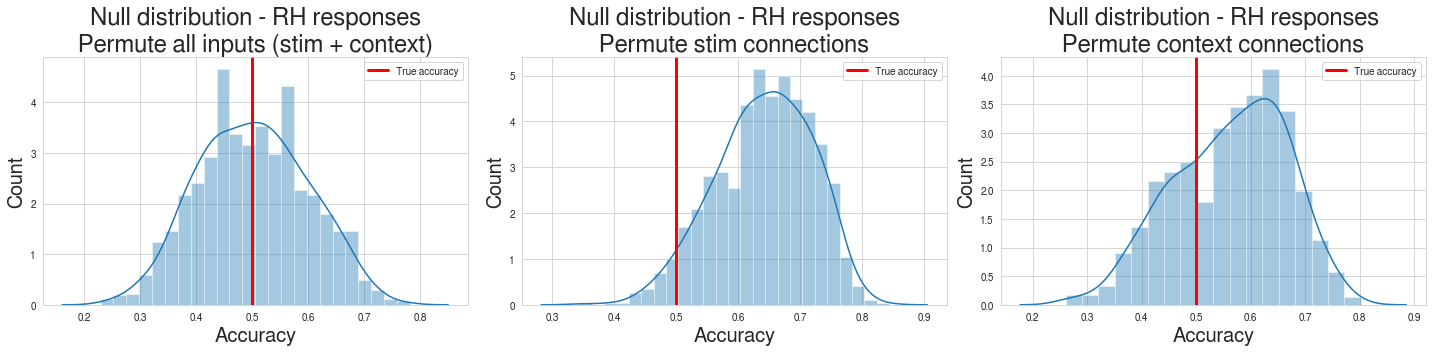

In [811]:
statistics_rh = np.zeros((distances_baseline_rh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_rh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_rh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_rh[0,0] = np.mean(distances_baseline_rh[0,:])
statistics_rh[0,1] = p

print('Activity flow accuracy =', statistics_rh[0,0])
print('p =', statistics_rh[0,1])
# print('Matched spatial correlation:', np.mean(rmatch))
# print('Mismatched spatial correlation:', np.mean(rmismatch))

plt.figure(figsize=(20,5))
plt.subplot(131)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_all.txt')
plt.title('Null distribution - RH responses\nPermute all inputs (stim + context)', fontsize=24)
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute all):', null_p)

plt.subplot(132)
plt.title('Null distribution - RH responses\nPermute stim connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_stim.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute stim):', null_p)

plt.subplot(133)
plt.title('Null distribution - RH responses\nPermute context connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_context.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute context):', null_p)


## 10 HIDDEN - Run across subject decoding on left-hand motor responses

#### Run decoding

In [812]:
tools_group = reload(tools_group)
nproc = 20
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputLH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

rois = np.asarray([187, 188, 231])
rois = np.asarray([188])
# rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])
    
# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_lh[roi_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_lh[roi_ind,:,:],axis=0).copy()
realdata = data_task_lh[roi_ind,:,:].copy()
flowdata = actflow_lh[roi_ind,:,:].copy()


distances_baseline_lh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_lh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,featsel=False,confusion=True,
                                                          ncvs=ncvs, nproc=nproc)
    

Activity flow accuracy = 0.2916666666666667
p = 0.9999999963640247
Permutation test p-value (permute all): 1.943


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Permutation test p-value (permute stim): 1.0
Permutation test p-value (permute context): 0.981


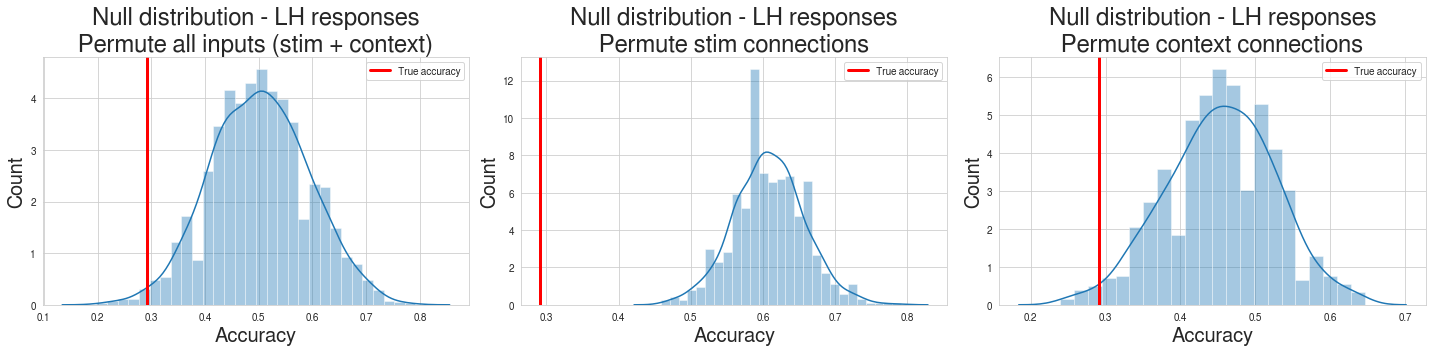

In [813]:
statistics_lh = np.zeros((distances_baseline_lh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_lh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_lh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_lh[0,0] = np.mean(distances_baseline_lh[0,:])
statistics_lh[0,1] = p

print('Activity flow accuracy =', statistics_lh[0,0])
print('p =', statistics_lh[0,1])
# print('Matched spatial correlation:', np.mean(rmatch))
# print('Mismatched spatial correlation:', np.mean(rmismatch))


plt.figure(figsize=(20,5))
plt.subplot(131)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_all.txt')
plt.title('Null distribution - LH responses\nPermute all inputs (stim + context)', fontsize=24)
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute all):', null_p)

plt.subplot(132)
plt.title('Null distribution - LH responses\nPermute stim connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_stim.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute stim):', null_p)

plt.subplot(133)
plt.title('Null distribution - LH responses\nPermute context connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_context.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute context):', null_p)


___

## Run analysis for Control (No threshold) variant

#### Compute average activity for each response, for each subject

In [814]:
scount = 0
actflow_rh_ctrl = np.zeros(data_task_rh.shape)
actflow_lh_ctrl = np.zeros(data_task_lh.shape)
for scount in range(len(subjNums)):
    # RMID
    actflow_rh_ctrl[target_ind,0,scount] = actflow_predictions_control[scount,:,2]
    # RIND
    actflow_rh_ctrl[target_ind,1,scount] = actflow_predictions_control[scount,:,3]
    # LMID
    actflow_lh_ctrl[target_ind,0,scount] = actflow_predictions_control[scount,:,0]
    # LIND
    actflow_lh_ctrl[target_ind,1,scount] = actflow_predictions_control[scount,:,1]


## 10 HIDDEN - (NO THRESHOLD CONTROL): Run across subject decoding on right-hand motor responses

#### Run decoding

In [815]:
tools_group = reload(tools_group)
nproc = 20
nResponses = 2
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]


# rois = np.asarray([8,52,9])-1
# rois = np.asarray([8,52])-1
# rois = np.where(networkdef==networkmappings['smn'])[0]
# rois = np.asarray([7,8,52])
rois = np.asarray([8])
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])

# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_rh[target_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_rh[target_ind,:,:],axis=0).copy()
realdata = data_task_rh[roi_ind,:,:].copy()
flowdata = actflow_rh_ctrl[roi_ind,:,:].copy()


distances_baseline_rh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_rh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,confusion=True,featsel=False,
                                                          ncvs=ncvs, nproc=nproc)

#### Compute statistics

In [816]:
statistics_rh = np.zeros((distances_baseline_rh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_rh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_rh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_rh[0,0] = np.mean(distances_baseline_rh[0,:])
statistics_rh[0,1] = p

print('Activity flow accuracy =', statistics_rh[0,0])
print('p =', statistics_rh[0,1])
print('Matched spatial correlation:', np.mean(rmatch))
print('Mismatched spatial correlation:', np.mean(rmismatch))



Activity flow accuracy = 0.4166666666666667
p = 0.9874919515363714
Matched spatial correlation: 0.003661721404899129
Mismatched spatial correlation: 0.007151086990278729


## 10 HIDDEN - (NO THRESHOLD CONTROL): Run across subject decoding on left-hand motor responses

#### Run decoding

In [817]:
tools_group = reload(tools_group)
nproc = 20
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputLH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]
# rois = np.asarray([188,189,232]) - 1
# rois = np.asarray([188,232]) - 1
# rois = np.asarray([189]) - 1
# rois = np.where(networkdef==networkmappings['smn'])[0]
# rois = np.asarray([187,188,231])
rois = np.asarray([188])
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])
    
# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_lh[roi_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_lh[roi_ind,:,:],axis=0).copy()
realdata = data_task_lh[roi_ind,:,:].copy()
flowdata = actflow_lh_ctrl[roi_ind,:,:].copy()


distances_baseline_lh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_lh[0,:],rmatch,rmismatch,confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,confusion=True,featsel=False,
                                                          ncvs=ncvs, nproc=nproc)
    

#### Compute statistics

In [818]:
statistics_lh = np.zeros((distances_baseline_lh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_lh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_lh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_lh[0,0] = np.mean(distances_baseline_lh[0,:])
statistics_lh[0,1] = p

print('Activity flow accuracy =', statistics_lh[0,0])
print('p =', statistics_lh[0,1])
print('Matched spatial correlation:', np.mean(rmatch))
print('Mismatched spatial correlation:', np.mean(rmismatch))



Activity flow accuracy = 0.5729166666666666
p = 0.02553237733908697
Matched spatial correlation: 0.0021522953250415595
Mismatched spatial correlation: -0.0012473545831905844


___

# 15 Hidden layers

#### Load in FC mappings

In [819]:
tools_group = reload(tools_group)
n_hiddenregions = -15
inputtypes = ['color','ori','pitch','constant']
inputkeys = ['RED','VERTICAL','HIGH','CONSTANT']
fc_input2hidden = {}
eig_input2hidden = {}
i = 0
for inputtype in inputtypes:
    fc_input2hidden[inputkeys[i]], eig_input2hidden[inputkeys[i]] = tools_group.loadGroupActFlowFC(inputtype, n_hiddenregions=n_hiddenregions, pc_space=True)
    i += 1

fc_12rule2hidden, eig_12rule2hidden = tools_group.loadGroupActFlowFC('12', n_hiddenregions=n_hiddenregions, pc_space=True)
# Load hidden to motor resp mappings
fc_hidden2motorresp, eig_hidden2motorresp = tools_group.loadGroupActFlowFC('hidden2out', n_hiddenregions=n_hiddenregions, pc_space=True)

#### Generate trials to simulate empirical brain computational models

In [820]:
esr = reload(esr)
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_15stims_v2.csv' # Good
filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_15stims_v3.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_6stims_v1.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_50stims_v1.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/tmp.csv'
# esr.constructTasks(n_stims=6,filename=filename)

trial_metadata = pd.read_csv(filename)

#### Define wrapper function for SRActFlow

In [821]:
esr = reload(esr)
def subjSRActFlow_12Rule_PCFC(subj,trial_metadata,n_hiddenregions):
    print('Subject ' + subj + '... Simulating ' + str(len(trial_metadata)) + ' Trials')
    obj = esr.EmpiricalActFlow(subj)
    # Input
    obj.fc_input2hidden = fc_input2hidden
    obj.eig_input2hidden = eig_input2hidden
    # Rules
    obj.fc_12rule2hidden = fc_12rule2hidden
    obj.eig_12rule2hidden = eig_12rule2hidden
    # hidden 2 motor
    obj.fc_hidden2motorresp = fc_hidden2motorresp
    obj.eig_hidden2motorresp = eig_hidden2motorresp
    
    obj.extractAllActivations(trial_metadata)

    actflow = obj.generateActFlowPredictions_12Rule_PCFC(thresh=0,n_hiddenregions=n_hiddenregions,verbose=False)
    actflow_control = obj.generateActFlowPredictions_12Rule_PCFC(thresh=None,n_hiddenregions=n_hiddenregions,verbose=False)
    del obj
    return actflow, actflow_control

global fc_input2hidden
global fc_12rule2hidden

inputs = []
for i in range(len(subjNums)):
    inputs.append((subjNums[i],trial_metadata,n_hiddenregions))

timestart = time.time()
pool = mp.Pool(processes=8)
results = pool.starmap_async(subjSRActFlow_12Rule_PCFC,inputs).get()
pool.close()
pool.join()
timeend = time.time()
print("time elapsed:", timeend-timestart)

actflow_predictions = np.zeros((len(subjNums),len(target_ind),4))
actflow_predictions_control = np.zeros((len(subjNums),len(target_ind),4))
scount = 0
for result in results:
    actflow_predictions[scount,:,:] = result[0]
    actflow_predictions_control[scount,:,:] = result[1]
    scount += 1



Subject 013... Simulating 960 Trials
Subject 017... Simulating 960 Trials
Subject 023... Simulating 960 Trials
Subject 027... Simulating 960 Trials
Subject 031... Simulating 960 Trials
Subject 034... Simulating 960 Trials
Subject 038... Simulating 960 Trials
Subject 041... Simulating 960 Trials
Subject 018... Simulating 960 Trials
Subject 042... Simulating 960 Trials
Subject 035... Simulating 960 Trials
Subject 032... Simulating 960 Trials
Subject 039... Simulating 960 Trials
Subject 024... Simulating 960 Trials
Subject 028... Simulating 960 Trials
Subject 014... Simulating 960 Trials
Subject 021... Simulating 960 Trials
Subject 043... Simulating 960 Trials
Subject 037... Simulating 960 Trials
Subject 033... Simulating 960 Trials
Subject 030... Simulating 960 Trials
Subject 026... Simulating 960 Trials
Subject 040... Simulating 960 Trials
Subject 016... Simulating 960 Trials
Subject 045... Simulating 960 Trials
Subject 048... Simulating 960 Trials
Subject 053... Simulating 960 Trials
S

#### Compute average activity for each response, for each subject

In [822]:
## Threshold
# scount = 0
# actflow_rh = np.zeros(data_task_rh.shape)
# actflow_lh = np.zeros(data_task_lh.shape)
# for scount in range(len(subjNums)):
#     # RMID
#     actflow_rh[target_ind,0,scount] = np.multiply(actflow_predictions[scount,:,2],actflow_predictions[scount,:,2]>0)
#     # RIND
#     actflow_rh[target_ind,1,scount] = np.multiply(actflow_predictions[scount,:,3],actflow_predictions[scount,:,3]>0)
#     # LMID
#     actflow_lh[target_ind,0,scount] = np.multiply(actflow_predictions[scount,:,0],actflow_predictions[scount,:,0]>0)
#     # LIND
#     actflow_lh[target_ind,1,scount] = np.multiply(actflow_predictions[scount,:,1],actflow_predictions[scount,:,1]>0)

    
## No threshold
scount = 0
actflow_rh = np.zeros(data_task_rh.shape)
actflow_lh = np.zeros(data_task_lh.shape)
for scount in range(len(subjNums)):
    # RMID
    actflow_rh[target_ind,0,scount] = actflow_predictions[scount,:,2]
    # RIND
    actflow_rh[target_ind,1,scount] = actflow_predictions[scount,:,3]
    # LMID
    actflow_lh[target_ind,0,scount] = actflow_predictions[scount,:,0]
    # LIND
    actflow_lh[target_ind,1,scount] = actflow_predictions[scount,:,1]


## 15 HIDDEN - Run across subject decoding on right-hand motor responses

#### Run decoding

In [823]:
tools_group = reload(tools_group)
nproc = 20
nResponses = 2
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

# rois = np.asarray([7,8,52])
rois = np.asarray([8])
# rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])

# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind
#
## realdata = stats.zscore(data_task_rh[target_ind,:,:],axis=0).copy()
## flowdata = stats.zscore(actflow_rh[target_ind,:,:],axis=0).copy()
realdata = data_task_rh[roi_ind,:,:].copy()
flowdata = actflow_rh[roi_ind,:,:].copy()


distances_baseline_rh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_rh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True, featsel=False,confusion=True,
                                                          ncvs=ncvs, nproc=nproc)

#### Compute statistics

Activity flow accuracy = 0.25
p = 0.9999999999987809
Permutation test p-value (permute all): 1.962


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Permutation test p-value (permute stim): 1.0
Permutation test p-value (permute context): 1.0


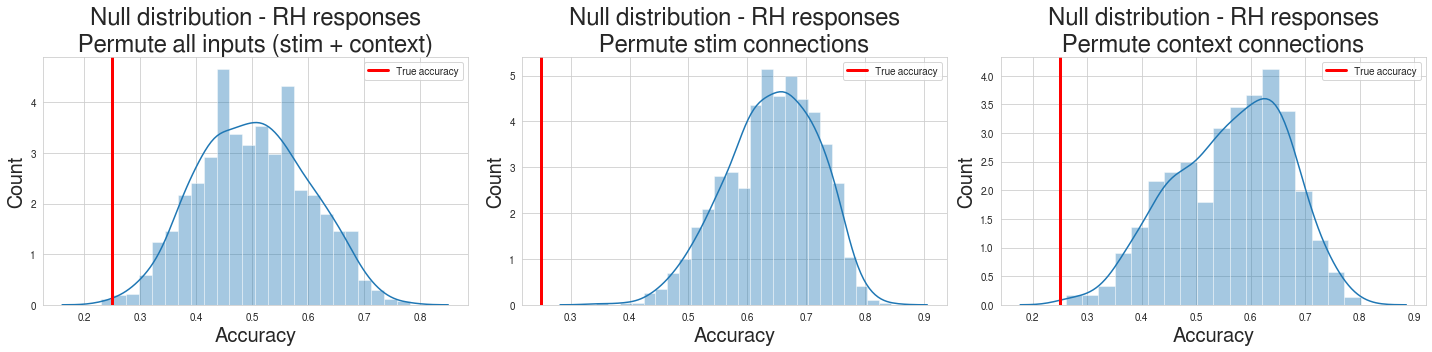

In [824]:
statistics_rh = np.zeros((distances_baseline_rh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_rh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_rh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_rh[0,0] = np.mean(distances_baseline_rh[0,:])
statistics_rh[0,1] = p

print('Activity flow accuracy =', statistics_rh[0,0])
print('p =', statistics_rh[0,1])
# print('Matched spatial correlation:', np.mean(rmatch))
# print('Mismatched spatial correlation:', np.mean(rmismatch))

plt.figure(figsize=(20,5))
plt.subplot(131)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_all.txt')
plt.title('Null distribution - RH responses\nPermute all inputs (stim + context)', fontsize=24)
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute all):', null_p)

plt.subplot(132)
plt.title('Null distribution - RH responses\nPermute stim connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_stim.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute stim):', null_p)

plt.subplot(133)
plt.title('Null distribution - RH responses\nPermute context connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_context.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute context):', null_p)


## 15 HIDDEN - Run across subject decoding on left-hand motor responses

#### Run decoding

In [825]:
tools_group = reload(tools_group)
nproc = 20
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputLH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

rois = np.asarray([187, 188, 231])
rois = np.asarray([188])
# rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])
    
# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_lh[roi_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_lh[roi_ind,:,:],axis=0).copy()
realdata = data_task_lh[roi_ind,:,:].copy()
flowdata = actflow_lh[roi_ind,:,:].copy()


distances_baseline_lh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_lh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,featsel=False,confusion=True,
                                                          ncvs=ncvs, nproc=nproc)
    

Activity flow accuracy = 0.65625
p = 8.903517788520931e-06
Permutation test p-value (permute all): 0.082


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Permutation test p-value (permute stim): 0.135
Permutation test p-value (permute context): 0.0


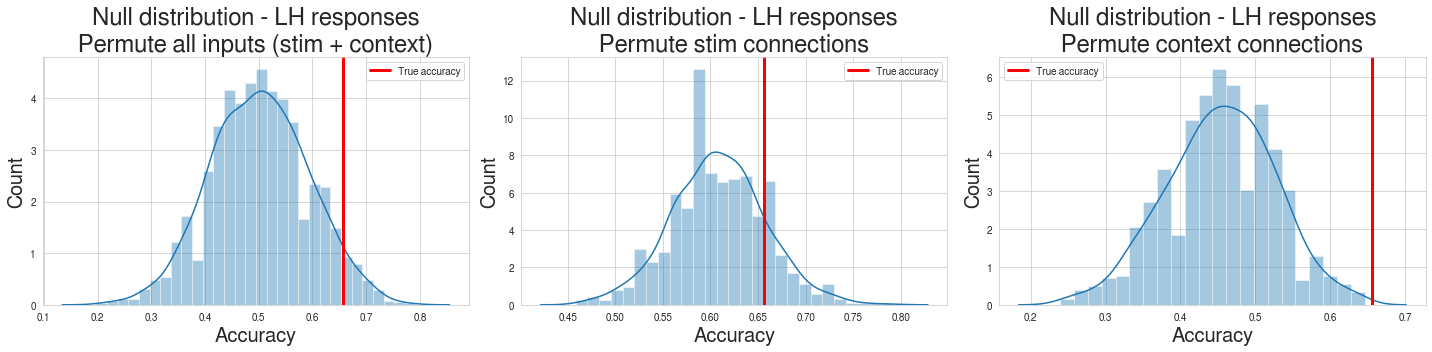

In [826]:
statistics_lh = np.zeros((distances_baseline_lh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_lh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_lh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_lh[0,0] = np.mean(distances_baseline_lh[0,:])
statistics_lh[0,1] = p

print('Activity flow accuracy =', statistics_lh[0,0])
print('p =', statistics_lh[0,1])
# print('Matched spatial correlation:', np.mean(rmatch))
# print('Mismatched spatial correlation:', np.mean(rmismatch))


plt.figure(figsize=(20,5))
plt.subplot(131)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_all.txt')
plt.title('Null distribution - LH responses\nPermute all inputs (stim + context)', fontsize=24)
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute all):', null_p)

plt.subplot(132)
plt.title('Null distribution - LH responses\nPermute stim connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_stim.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute stim):', null_p)

plt.subplot(133)
plt.title('Null distribution - LH responses\nPermute context connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_context.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute context):', null_p)


___

## Run analysis for Control (No threshold) variant

#### Compute average activity for each response, for each subject

In [827]:
scount = 0
actflow_rh_ctrl = np.zeros(data_task_rh.shape)
actflow_lh_ctrl = np.zeros(data_task_lh.shape)
for scount in range(len(subjNums)):
    # RMID
    actflow_rh_ctrl[target_ind,0,scount] = actflow_predictions_control[scount,:,2]
    # RIND
    actflow_rh_ctrl[target_ind,1,scount] = actflow_predictions_control[scount,:,3]
    # LMID
    actflow_lh_ctrl[target_ind,0,scount] = actflow_predictions_control[scount,:,0]
    # LIND
    actflow_lh_ctrl[target_ind,1,scount] = actflow_predictions_control[scount,:,1]


## 15 HIDDEN - (NO THRESHOLD CONTROL): Run across subject decoding on right-hand motor responses

#### Run decoding

In [828]:
tools_group = reload(tools_group)
nproc = 20
nResponses = 2
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]


# rois = np.asarray([8,52,9])-1
# rois = np.asarray([8,52])-1
# rois = np.where(networkdef==networkmappings['smn'])[0]
# rois = np.asarray([7,8,52])
rois = np.asarray([8])
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])

# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_rh[target_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_rh[target_ind,:,:],axis=0).copy()
realdata = data_task_rh[roi_ind,:,:].copy()
flowdata = actflow_rh_ctrl[roi_ind,:,:].copy()


distances_baseline_rh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_rh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,confusion=True,featsel=False,
                                                          ncvs=ncvs, nproc=nproc)

#### Compute statistics

In [829]:
statistics_rh = np.zeros((distances_baseline_rh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_rh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_rh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_rh[0,0] = np.mean(distances_baseline_rh[0,:])
statistics_rh[0,1] = p

print('Activity flow accuracy =', statistics_rh[0,0])
print('p =', statistics_rh[0,1])
print('Matched spatial correlation:', np.mean(rmatch))
print('Mismatched spatial correlation:', np.mean(rmismatch))



Activity flow accuracy = 0.5104166666666666
p = 0.41433171458648865
Matched spatial correlation: -0.0013973084988003117
Mismatched spatial correlation: -0.0006711788821316481


## 15 HIDDEN - (NO THRESHOLD CONTROL): Run across subject decoding on left-hand motor responses

#### Run decoding

In [830]:
tools_group = reload(tools_group)
nproc = 20
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputLH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]
# rois = np.asarray([188,189,232]) - 1
# rois = np.asarray([188,232]) - 1
# rois = np.asarray([189]) - 1
# rois = np.where(networkdef==networkmappings['smn'])[0]
# rois = np.asarray([187,188,231])
rois = np.asarray([188])
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])
    
# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_lh[roi_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_lh[roi_ind,:,:],axis=0).copy()
realdata = data_task_lh[roi_ind,:,:].copy()
flowdata = actflow_lh_ctrl[roi_ind,:,:].copy()


distances_baseline_lh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_lh[0,:],rmatch,rmismatch,confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,confusion=True,featsel=False,
                                                          ncvs=ncvs, nproc=nproc)
    

#### Compute statistics

In [831]:
statistics_lh = np.zeros((distances_baseline_lh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_lh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_lh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_lh[0,0] = np.mean(distances_baseline_lh[0,:])
statistics_lh[0,1] = p

print('Activity flow accuracy =', statistics_lh[0,0])
print('p =', statistics_lh[0,1])
print('Matched spatial correlation:', np.mean(rmatch))
print('Mismatched spatial correlation:', np.mean(rmismatch))



Activity flow accuracy = 0.484375
p = 0.6408405728911661
Matched spatial correlation: 0.0030590970237778996
Mismatched spatial correlation: 0.004442907884302758


___

___

# 20 Hidden layers

#### Load in FC mappings

In [832]:
tools_group = reload(tools_group)
n_hiddenregions = -20
inputtypes = ['color','ori','pitch','constant']
inputkeys = ['RED','VERTICAL','HIGH','CONSTANT']
fc_input2hidden = {}
eig_input2hidden = {}
i = 0
for inputtype in inputtypes:
    fc_input2hidden[inputkeys[i]], eig_input2hidden[inputkeys[i]] = tools_group.loadGroupActFlowFC(inputtype, n_hiddenregions=n_hiddenregions, pc_space=True)
    i += 1

fc_12rule2hidden, eig_12rule2hidden = tools_group.loadGroupActFlowFC('12', n_hiddenregions=n_hiddenregions, pc_space=True)
# Load hidden to motor resp mappings
fc_hidden2motorresp, eig_hidden2motorresp = tools_group.loadGroupActFlowFC('hidden2out', n_hiddenregions=n_hiddenregions, pc_space=True)

#### Generate trials to simulate empirical brain computational models

In [833]:
esr = reload(esr)
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_15stims_v2.csv' # Good
filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_15stims_v3.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_6stims_v1.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_50stims_v1.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/tmp.csv'
# esr.constructTasks(n_stims=6,filename=filename)

trial_metadata = pd.read_csv(filename)

#### Define wrapper function for SRActFlow

In [834]:
esr = reload(esr)
def subjSRActFlow_12Rule_PCFC(subj,trial_metadata,n_hiddenregions):
    print('Subject ' + subj + '... Simulating ' + str(len(trial_metadata)) + ' Trials')
    obj = esr.EmpiricalActFlow(subj)
    # Input
    obj.fc_input2hidden = fc_input2hidden
    obj.eig_input2hidden = eig_input2hidden
    # Rules
    obj.fc_12rule2hidden = fc_12rule2hidden
    obj.eig_12rule2hidden = eig_12rule2hidden
    # hidden 2 motor
    obj.fc_hidden2motorresp = fc_hidden2motorresp
    obj.eig_hidden2motorresp = eig_hidden2motorresp
    
    obj.extractAllActivations(trial_metadata)

    actflow = obj.generateActFlowPredictions_12Rule_PCFC(thresh=0,n_hiddenregions=n_hiddenregions,verbose=False)
    actflow_control = obj.generateActFlowPredictions_12Rule_PCFC(thresh=None,n_hiddenregions=n_hiddenregions,verbose=False)
    del obj
    return actflow, actflow_control

global fc_input2hidden
global fc_12rule2hidden

inputs = []
for i in range(len(subjNums)):
    inputs.append((subjNums[i],trial_metadata,n_hiddenregions))

timestart = time.time()
pool = mp.Pool(processes=8)
results = pool.starmap_async(subjSRActFlow_12Rule_PCFC,inputs).get()
pool.close()
pool.join()
timeend = time.time()
print("time elapsed:", timeend-timestart)

actflow_predictions = np.zeros((len(subjNums),len(target_ind),4))
actflow_predictions_control = np.zeros((len(subjNums),len(target_ind),4))
scount = 0
for result in results:
    actflow_predictions[scount,:,:] = result[0]
    actflow_predictions_control[scount,:,:] = result[1]
    scount += 1



Subject 013... Simulating 960 Trials
Subject 023... Simulating 960 Trials
Subject 031... Simulating 960 Trials
Subject 027... Simulating 960 Trials
Subject 017... Simulating 960 Trials
Subject 034... Simulating 960 Trials
Subject 038... Simulating 960 Trials
Subject 041... Simulating 960 Trials
Subject 014... Simulating 960 Trials
Subject 028... Simulating 960 Trials
Subject 024... Simulating 960 Trials
Subject 039... Simulating 960 Trials
Subject 035... Simulating 960 Trials
Subject 018... Simulating 960 Trials
Subject 042... Simulating 960 Trials
Subject 032... Simulating 960 Trials
Subject 026... Simulating 960 Trials
Subject 016... Simulating 960 Trials
Subject 030... Simulating 960 Trials
Subject 037... Simulating 960 Trials
Subject 021... Simulating 960 Trials
Subject 040... Simulating 960 Trials
Subject 033... Simulating 960 Trials
Subject 043... Simulating 960 Trials
Subject 045... Simulating 960 Trials
Subject 048... Simulating 960 Trials
Subject 053... Simulating 960 Trials
S

#### Compute average activity for each response, for each subject

In [835]:
## Threshold
# scount = 0
# actflow_rh = np.zeros(data_task_rh.shape)
# actflow_lh = np.zeros(data_task_lh.shape)
# for scount in range(len(subjNums)):
#     # RMID
#     actflow_rh[target_ind,0,scount] = np.multiply(actflow_predictions[scount,:,2],actflow_predictions[scount,:,2]>0)
#     # RIND
#     actflow_rh[target_ind,1,scount] = np.multiply(actflow_predictions[scount,:,3],actflow_predictions[scount,:,3]>0)
#     # LMID
#     actflow_lh[target_ind,0,scount] = np.multiply(actflow_predictions[scount,:,0],actflow_predictions[scount,:,0]>0)
#     # LIND
#     actflow_lh[target_ind,1,scount] = np.multiply(actflow_predictions[scount,:,1],actflow_predictions[scount,:,1]>0)

    
## No threshold
scount = 0
actflow_rh = np.zeros(data_task_rh.shape)
actflow_lh = np.zeros(data_task_lh.shape)
for scount in range(len(subjNums)):
    # RMID
    actflow_rh[target_ind,0,scount] = actflow_predictions[scount,:,2]
    # RIND
    actflow_rh[target_ind,1,scount] = actflow_predictions[scount,:,3]
    # LMID
    actflow_lh[target_ind,0,scount] = actflow_predictions[scount,:,0]
    # LIND
    actflow_lh[target_ind,1,scount] = actflow_predictions[scount,:,1]


## 20 HIDDEN - Run across subject decoding on right-hand motor responses

#### Run decoding

In [836]:
tools_group = reload(tools_group)
nproc = 20
nResponses = 2
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

# rois = np.asarray([7,8,52])
rois = np.asarray([8])
# rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])

# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind
#
## realdata = stats.zscore(data_task_rh[target_ind,:,:],axis=0).copy()
## flowdata = stats.zscore(actflow_rh[target_ind,:,:],axis=0).copy()
realdata = data_task_rh[roi_ind,:,:].copy()
flowdata = actflow_rh[roi_ind,:,:].copy()


distances_baseline_rh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_rh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True, featsel=False,confusion=True,
                                                          ncvs=ncvs, nproc=nproc)

#### Compute statistics

Activity flow accuracy = 0.5729166666666666
p = 0.02553237733908697
Permutation test p-value (permute all): 0.457


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Permutation test p-value (permute stim): 0.787
Permutation test p-value (permute context): 0.491


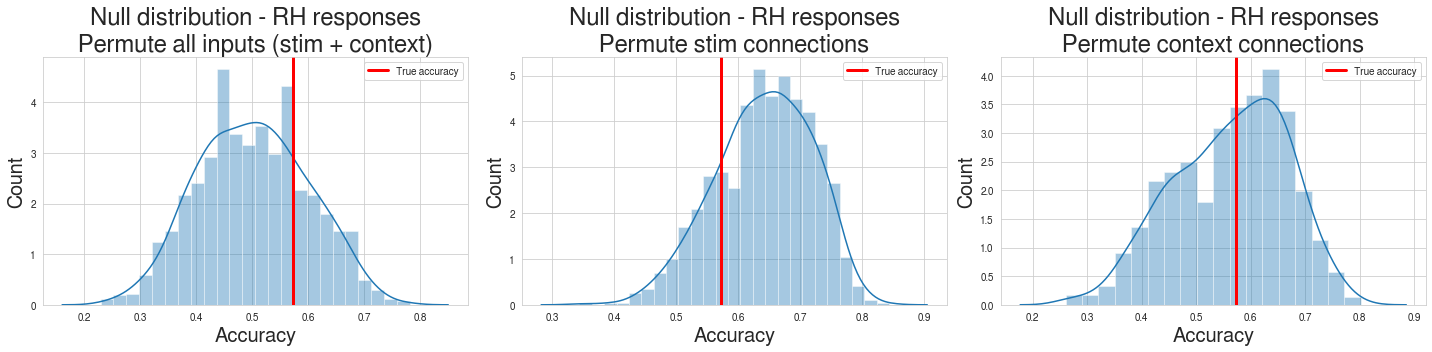

In [837]:
statistics_rh = np.zeros((distances_baseline_rh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_rh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_rh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_rh[0,0] = np.mean(distances_baseline_rh[0,:])
statistics_rh[0,1] = p

print('Activity flow accuracy =', statistics_rh[0,0])
print('p =', statistics_rh[0,1])
# print('Matched spatial correlation:', np.mean(rmatch))
# print('Mismatched spatial correlation:', np.mean(rmismatch))

plt.figure(figsize=(20,5))
plt.subplot(131)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_all.txt')
plt.title('Null distribution - RH responses\nPermute all inputs (stim + context)', fontsize=24)
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute all):', null_p)

plt.subplot(132)
plt.title('Null distribution - RH responses\nPermute stim connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_stim.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute stim):', null_p)

plt.subplot(133)
plt.title('Null distribution - RH responses\nPermute context connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_RH_context.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_rh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_rh[0,0])/1000.0
print('Permutation test p-value (permute context):', null_p)


## 20 HIDDEN - Run across subject decoding on left-hand motor responses

#### Run decoding

In [838]:
tools_group = reload(tools_group)
nproc = 20
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputLH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

rois = np.asarray([187, 188, 231])
rois = np.asarray([188])
# rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])
    
# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_lh[roi_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_lh[roi_ind,:,:],axis=0).copy()
realdata = data_task_lh[roi_ind,:,:].copy()
flowdata = actflow_lh[roi_ind,:,:].copy()


distances_baseline_lh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_lh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,featsel=False,confusion=True,
                                                          ncvs=ncvs, nproc=nproc)
    

Activity flow accuracy = 0.4270833333333333
p = 0.974467622660913
Permutation test p-value (permute all): 1.519


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Permutation test p-value (permute stim): 1.0
Permutation test p-value (permute context): 0.624


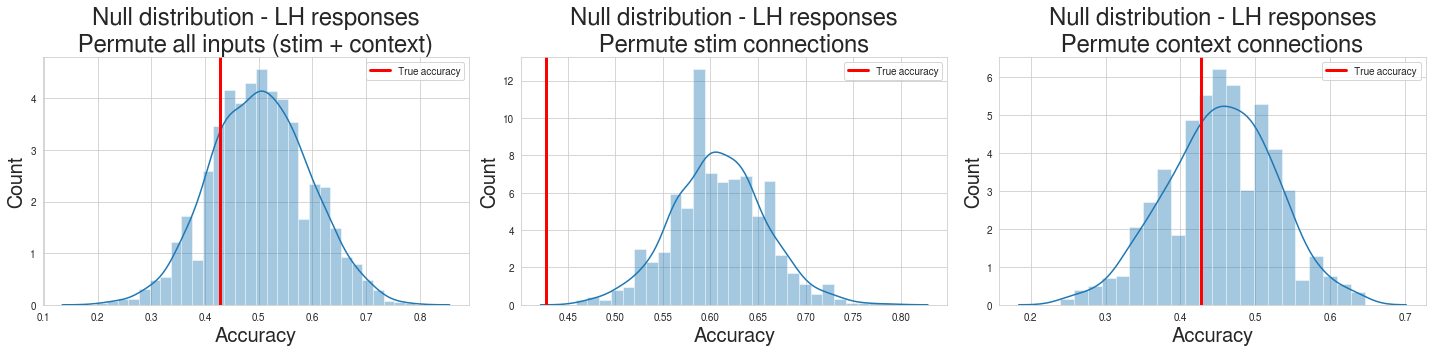

In [839]:
statistics_lh = np.zeros((distances_baseline_lh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_lh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_lh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_lh[0,0] = np.mean(distances_baseline_lh[0,:])
statistics_lh[0,1] = p

print('Activity flow accuracy =', statistics_lh[0,0])
print('p =', statistics_lh[0,1])
# print('Matched spatial correlation:', np.mean(rmatch))
# print('Mismatched spatial correlation:', np.mean(rmismatch))


plt.figure(figsize=(20,5))
plt.subplot(131)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_all.txt')
plt.title('Null distribution - LH responses\nPermute all inputs (stim + context)', fontsize=24)
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute all):', null_p)

plt.subplot(132)
plt.title('Null distribution - LH responses\nPermute stim connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_stim.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute stim):', null_p)

plt.subplot(133)
plt.title('Null distribution - LH responses\nPermute context connections', fontsize=24)
acc_permutation = np.loadtxt('../../data/results/GroupfMRI/GroupfMRI15c_ConnectivityPermutation/PermutationTest_ConnectivityRewire_LH_context.txt')
sns.distplot(acc_permutation)
plt.axvline(x=statistics_lh[0,0],color='r',linewidth=3.0,label='True accuracy')
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend()
plt.tight_layout()
null_p = np.sum(acc_permutation>statistics_lh[0,0])/1000.0
print('Permutation test p-value (permute context):', null_p)


___

## Run analysis for Control (No threshold) variant

#### Compute average activity for each response, for each subject

In [840]:
scount = 0
actflow_rh_ctrl = np.zeros(data_task_rh.shape)
actflow_lh_ctrl = np.zeros(data_task_lh.shape)
for scount in range(len(subjNums)):
    # RMID
    actflow_rh_ctrl[target_ind,0,scount] = actflow_predictions_control[scount,:,2]
    # RIND
    actflow_rh_ctrl[target_ind,1,scount] = actflow_predictions_control[scount,:,3]
    # LMID
    actflow_lh_ctrl[target_ind,0,scount] = actflow_predictions_control[scount,:,0]
    # LIND
    actflow_lh_ctrl[target_ind,1,scount] = actflow_predictions_control[scount,:,1]


## 20 HIDDEN - (NO THRESHOLD CONTROL): Run across subject decoding on right-hand motor responses

#### Run decoding

In [841]:
tools_group = reload(tools_group)
nproc = 20
nResponses = 2
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]


# rois = np.asarray([8,52,9])-1
# rois = np.asarray([8,52])-1
# rois = np.where(networkdef==networkmappings['smn'])[0]
# rois = np.asarray([7,8,52])
rois = np.asarray([8])
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])

# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_rh[target_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_rh[target_ind,:,:],axis=0).copy()
realdata = data_task_rh[roi_ind,:,:].copy()
flowdata = actflow_rh_ctrl[roi_ind,:,:].copy()


distances_baseline_rh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_rh[0,:],rmatch,rmismatch, confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,confusion=True,featsel=False,
                                                          ncvs=ncvs, nproc=nproc)

#### Compute statistics

In [842]:
statistics_rh = np.zeros((distances_baseline_rh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_rh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_rh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_rh[0,0] = np.mean(distances_baseline_rh[0,:])
statistics_rh[0,1] = p

print('Activity flow accuracy =', statistics_rh[0,0])
print('p =', statistics_rh[0,1])
print('Matched spatial correlation:', np.mean(rmatch))
print('Mismatched spatial correlation:', np.mean(rmismatch))



Activity flow accuracy = 0.5520833333333334
p = 0.08507392979818243
Matched spatial correlation: 0.0011496957172679914
Mismatched spatial correlation: -0.0013484670022160274


## 20 HIDDEN - (NO THRESHOLD CONTROL): Run across subject decoding on left-hand motor responses

#### Run decoding

In [843]:
tools_group = reload(tools_group)
nproc = 20
ncvs = 1

tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputLH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]
# rois = np.asarray([188,189,232]) - 1
# rois = np.asarray([188,232]) - 1
# rois = np.asarray([189]) - 1
# rois = np.where(networkdef==networkmappings['smn'])[0]
# rois = np.asarray([187,188,231])
rois = np.asarray([188])
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])
    
# roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_lh[roi_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_lh[roi_ind,:,:],axis=0).copy()
realdata = data_task_lh[roi_ind,:,:].copy()
flowdata = actflow_lh_ctrl[roi_ind,:,:].copy()


distances_baseline_lh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_lh[0,:],rmatch,rmismatch,confusion_mats = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,confusion=True,featsel=False,
                                                          ncvs=ncvs, nproc=nproc)
    

#### Compute statistics

In [844]:
statistics_lh = np.zeros((distances_baseline_lh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_lh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_lh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_lh[0,0] = np.mean(distances_baseline_lh[0,:])
statistics_lh[0,1] = p

print('Activity flow accuracy =', statistics_lh[0,0])
print('p =', statistics_lh[0,1])
print('Matched spatial correlation:', np.mean(rmatch))
print('Mismatched spatial correlation:', np.mean(rmismatch))



Activity flow accuracy = 0.484375
p = 0.6408405728911661
Matched spatial correlation: -0.0004061241827032549
Mismatched spatial correlation: -0.0003506408572602835


___